In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats


In [2]:
# %matplotlib notebook

In [2]:
D0 = scipy.stats.norm(0, np.sqrt(0.018/5))
D1 = scipy.stats.norm(0.003, np.sqrt(0.018/5))
print(D0.pdf(0.001)*0.5/(D0.pdf(0.001)*0.5 + D1.pdf(0.001)*0.5))
plt.plot(np.linspace(-.15, .15, 100), D0.pdf(np.linspace(-.15, .15, 100)))
plt.plot(np.linspace(-.15, .15, 100), D1.pdf(np.linspace(-.15, .15, 100)))

0.5001041666651597


# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [29]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    # x and y
    x = np.linspace(a,b,n+1)
    y= np.linspace(c,d, n+1)
    h = (b-a)/n

    # build matrix A
    T = sp.diags([np.ones(n-2), -4*np.ones(n-1), np.ones(n-2)], [-1,0,1])
    I = sp.diags([np.ones(n-1)], [0])
    Z = sp.diags([np.zeros(n-1)], [0])
    A = (1/(h**2)) * sp.vstack(
        [sp.hstack(
            [Z for j in range(n-i, n-1)] + 
            [I for j in range(1) if i > 0] + 
            [T] + 
            [I for j in range(1) if i < n-2] + 
            [Z for j in range(2+i, n-1)]) 
        for i in range(n-1)])
    
    A = A.tocsr()

    # build p and q, and F
    p = (1/(h**2)) * np.hstack(
        [np.hstack(
            [g(a, y[j])] + 
            [0 for i in range(n-3)] + 
            [g(b, y[j])]) 
        for j in range(1, n)])
    
    q = (1/(h**2)) * np.hstack(
        [g(x[i], c) for i in range(1, n)] + 
        [0 for i in range((n-1)*(n-3))] + 
        [g(x[i], d) for i in range(1, n)])
    
    F = np.hstack([[f(x[i], y[j]) for i in range(1, n)] for j in range(1,n)])
    
    # make p, q, F sparse matrices
    p = sp.csr_matrix(p)
    q = sp.csr_matrix(q)
    F = sp.csr_matrix(F)

    # solve AU = B = F - p - q
    B = F - p - q
    B = B.reshape(-1, 1)
    # print(A.shape)
    # print(B.shape)
    U_inner = spla.spsolve(A, B).reshape((n-1, n-1))
    # print(U_inner.shape)
    # print(U_inner)

    # create U_full
    U_full = np.zeros((n+1, n+1))
    # print("without_inner:", U_full)
    U_full[1:n, 1:n] = U_inner
    # print("with inner:", U_full)
    U_full[0, :] = np.array([g(x[i], c) for i in range(n+1)])
    # print("with first row:", U_full)
    U_full[n, :] = np.array([g(x[i], d) for i in range(n+1)])
    U_full[:, 0] = np.array([g(a, y[i]) for i in range(n+1)])
    U_full[:, n] = np.array([g(b, y[i]) for i in range(n+1)])

    return U_full


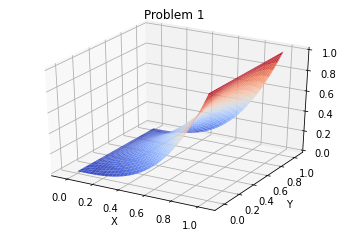

In [32]:
n = 100
a,b,c,d = 0, 1, 0, 1
f = lambda x,y: 0
g = lambda x,y: x**3

U_full = poisson_square(a,b,c,d,f,g,n)

## PLOT

# set up figure and axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim((-.1+a,.1+b))
ax.set_ylim((-.1+c,.1+d))
# ax.set_zlim((-1.1,1.1))

# x and y
x = np.linspace(a,b,n+1)
y= np.linspace(c,d, n+1)
X, Y = np.meshgrid(x, y)
# print(X.shape, U_full.shape)
ax.plot_surface(X, Y, U_full, cmap="coolwarm")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Problem 1")
plt.show()

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

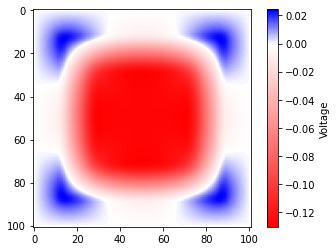

In [39]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

plt.imshow(source(X,Y),cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))))
plt.colorbar(label="Relative Charge")
plt.show()

g = lambda x, y: 0
f = lambda x,y: -1*source(x,y)

U_full = poisson_square(a,b,c,d, f, g, n)
X = np.linspace(a1,b1,n+1)
Y = np.linspace(c1,d1,n+1)
X,Y = np.meshgrid(X,Y)

plt.imshow(U_full,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(U_full)))
plt.colorbar(label="Voltage")
plt.show()